In [5]:
from ordinalgbt.lgb import LGBMOrdinal
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.stats import uniform, loguniform, randint

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import shap
from shap import TreeExplainer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from ordinalgbt.data import make_ordinal_classification
from ordinalgbt.lgb import LGBMOrdinal


# from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import make_scorer, cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score, cohen_kappa_score, classification_report, accuracy_score
from scipy.stats import kendalltau

import warnings
warnings.filterwarnings("ignore")

# Data Preparation

In [2]:
test_df = pd.read_csv('/Users/liusiyi/Desktop/BT4240/Group Project/dataset/test_data_v3.csv')
valid_df = pd.read_csv('/Users/liusiyi/Desktop/BT4240/Group Project/dataset/validate_data_v3.csv')
train_df = pd.read_csv('/Users/liusiyi/Desktop/BT4240/Group Project/dataset/train_data_v3.csv')

In [3]:
train_X = train_df.drop(columns=['Severity'],inplace=False)
train_y = train_df['Severity']
valid_X = valid_df.drop(columns=['Severity'],inplace=False)
valid_y = valid_df['Severity']
test_X = test_df.drop(columns=['Severity'],inplace=False)
test_y = test_df['Severity']

encoder = LabelEncoder()
train_y1 = encoder.fit_transform(train_y)
valid_y1 = encoder.transform(valid_y)
test_y1 = encoder.transform(test_y)


In [6]:
def evaluate_results(y_pred, y_pred_prob, y_true):
    

    accuracy = accuracy_score(y_true, y_pred)
    tolerance_accuracy = np.mean(np.abs(y_true - y_pred) <= 1)
    f1_macro = f1_score(y_true, y_pred, average="macro")
    f1_weighted = f1_score(y_true, y_pred, average="weighted")
    tau, _ = kendalltau(y_true, y_pred)
    kappa_weighted = cohen_kappa_score(y_true, y_pred, weights="quadratic")



    print("Accuracy:", accuracy)
    print("Accuracy within 1 class:", tolerance_accuracy)
    print("F1-score (Macro):", f1_macro)
    print("F1-score (Weighted):", f1_weighted)
    print("Kendall's Tau:", tau)
    print("Weighted Kappa:", kappa_weighted)
    print(classification_report(y_true, y_pred))

    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

    y_true_bin = label_binarize(y_true, classes=np.unique(y_true))

    n_classes = y_true_bin.shape[1]
    plt.figure(figsize=(8,6))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Multi-Class)")
    plt.legend()
    plt.show()

# Best Model
Best parameters:  OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.5170352556204258), ('max_depth', 256), ('n_estimators', 3824), ('num_leaves', 265), ('reg_alpha', 10.295908952476346), ('reg_lambda', 0.5), ('subsample', 1.0), ('subsample_freq', 2)])

Selected features:  Index(['End_Time', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Crossing',
       'Traffic_Signal', 'Duration', 'Region', 'State_Others', 'Weather_Year',
       'Weather_Month', 'Weather_Day'],
      dtype='object')

In [4]:
selected_features_15 = ['End_Time', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Crossing',
       'Traffic_Signal', 'Duration', 'Region', 'State_Others', 'Weather_Year',
       'Weather_Month', 'Weather_Day']

model = LGBMOrdinal(
    colsample_bytree=1.0,
    learning_rate=0.5170352556204258,
    max_depth=256,
    n_estimators=3824,
    num_leaves=256,
    reg_alpha=10.295908952476346,
    reg_lambda=0.5,
    subsample=1.0,
    subsample_freq=2
)

In [10]:
model.fit(train_X[selected_features_15], train_y1)

LGBMOrdinal(learning_rate=0.5170352556204258, max_depth=256, n_estimators=3824,
            num_leaves=256,
            objective=<function LGBMOrdinal._lgb_loss_factory.<locals>.loss at 0x16d697640>,
            reg_alpha=10.295908952476346, reg_lambda=0.5, subsample_freq=2)

# Test Results across 20 test samples

In [11]:
# Store metrics
f1_scores = []
accuracy_1_scores = []
accuracy_2_scores = []

for i in range(1, 21):
    path = f"../../data/split_{i}.csv"

    # Load data
    test = pd.read_csv(path)
    y_test = test['Severity']
    X_test = test.drop(columns=['Severity'])
    encoder = LabelEncoder()
    y_test1 = encoder.fit_transform(y_test)

    # Use previously selected features
    X_test_selected = X_test[selected_features_15]
    

    # Predict
    y_pred = model.predict(X_test_selected)

    # Metric 1: Weighted F1 Score
    f1 = f1_score(y_test1, y_pred, average='weighted')
    f1_scores.append(f1)

    # Metric 2: Accuracy1 (Exact match)
    acc1 = np.mean(y_pred == y_test1)
    accuracy_1_scores.append(acc1)

    # Metric 3: Accuracy2 (±1 of true label)
    acc2 = np.mean(np.abs(y_pred - y_test1) <= 1)
    accuracy_2_scores.append(acc2)

    print(f"Dataset {i:02d} - F1: {f1:.4f} | Accuracy1: {acc1:.4f} | Accuracy2: {acc2:.4f}")

Dataset 01 - F1: 0.5518 | Accuracy1: 0.4510 | Accuracy2: 0.7350
Dataset 02 - F1: 0.5257 | Accuracy1: 0.4220 | Accuracy2: 0.7060
Dataset 03 - F1: 0.5567 | Accuracy1: 0.4480 | Accuracy2: 0.7350
Dataset 04 - F1: 0.5447 | Accuracy1: 0.4420 | Accuracy2: 0.7220
Dataset 05 - F1: 0.5571 | Accuracy1: 0.4550 | Accuracy2: 0.7480
Dataset 06 - F1: 0.5657 | Accuracy1: 0.4680 | Accuracy2: 0.7400
Dataset 07 - F1: 0.5465 | Accuracy1: 0.4360 | Accuracy2: 0.7110
Dataset 08 - F1: 0.5591 | Accuracy1: 0.4500 | Accuracy2: 0.7240
Dataset 09 - F1: 0.5363 | Accuracy1: 0.4360 | Accuracy2: 0.7190
Dataset 10 - F1: 0.5361 | Accuracy1: 0.4360 | Accuracy2: 0.7370
Dataset 11 - F1: 0.5401 | Accuracy1: 0.4320 | Accuracy2: 0.7420
Dataset 12 - F1: 0.5336 | Accuracy1: 0.4290 | Accuracy2: 0.7230
Dataset 13 - F1: 0.5387 | Accuracy1: 0.4260 | Accuracy2: 0.7370
Dataset 14 - F1: 0.5546 | Accuracy1: 0.4540 | Accuracy2: 0.7310
Dataset 15 - F1: 0.5164 | Accuracy1: 0.4100 | Accuracy2: 0.7140
Dataset 16 - F1: 0.5426 | Accuracy1: 0.4

In [12]:
# Convert lists to arrays
f1_scores = np.array(f1_scores)
accuracy_1_scores = np.array(accuracy_1_scores)
accuracy_2_scores = np.array(accuracy_2_scores)

# Plot mean & std

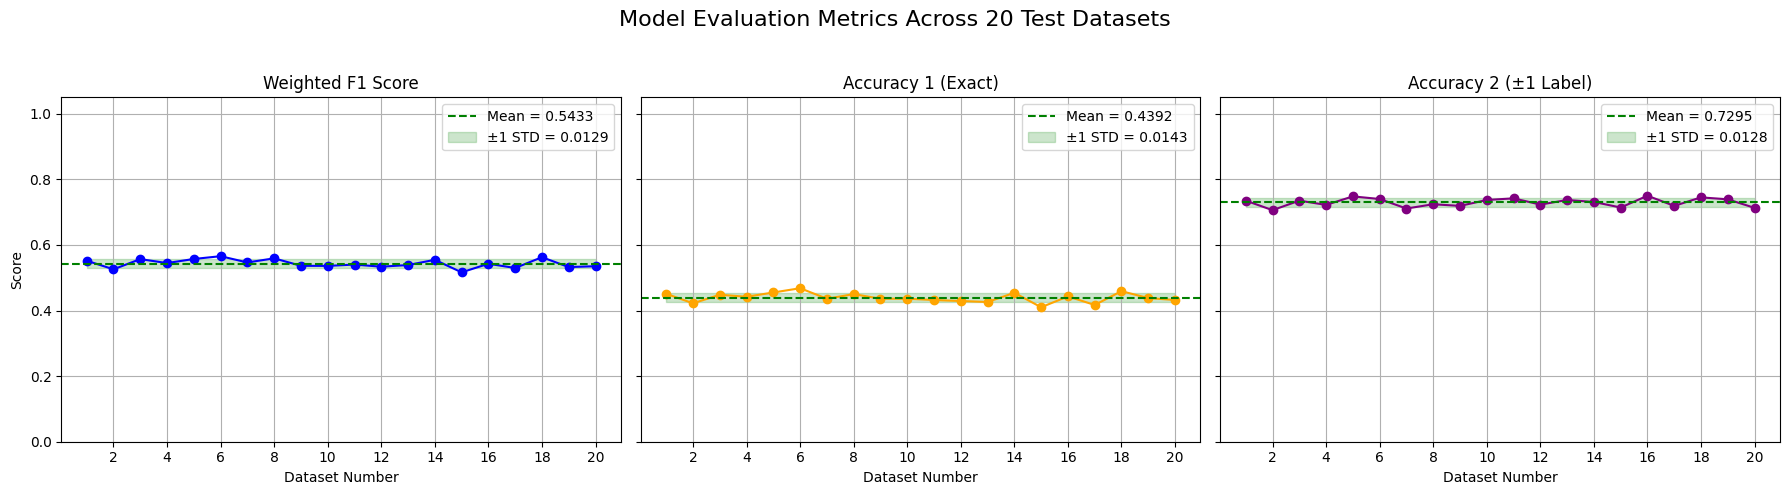

In [14]:
# Plotting: 1 row, 3 columns
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

metrics = [f1_scores, accuracy_1_scores, accuracy_2_scores]
titles = ['Weighted F1 Score', 'Accuracy 1 (Exact)', 'Accuracy 2 (±1 Label)']
colors = ['blue', 'orange', 'purple']

for i in range(3):
    axs[i].plot(range(1, 21), metrics[i], marker='o', color=colors[i])
    axs[i].set_title(titles[i])
    axs[i].set_xlabel("Dataset Number")
    axs[i].set_xticks(range(2, 21, 2))  # Show only even-numbered ticks
    axs[i].set_ylim(0, 1.05)
    axs[i].grid(True)

    mean_score = np.mean(metrics[i])
    std_dev = np.std(metrics[i])
    axs[i].axhline(mean_score, color='green', linestyle='--', label=f'Mean = {mean_score:.4f}')
    axs[i].fill_between(range(1, 21),
                        mean_score - std_dev,
                        mean_score + std_dev,
                        color='green', alpha=0.2,
                        label=f'±1 STD = {std_dev:.4f}')
    axs[i].legend()


axs[0].set_ylabel("Score")
plt.suptitle("Model Evaluation Metrics Across 20 Test Datasets", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Coefficient of Variation (CV)

In [15]:
cv_f1 = np.std(f1_scores) / np.mean(f1_scores)
cv_acc1 = np.std(accuracy_1_scores) / np.mean(accuracy_1_scores)
cv_acc2 = np.std(accuracy_2_scores) / np.mean(accuracy_2_scores)

print(f"CV Weighted F1 Score: {cv_f1:.4f}")
print(f"CV Accuracy 1: {cv_acc1:.4f}")
print(f"CV Accuracy 2: {cv_acc2:.4f}")

CV Weighted F1 Score: 0.0238
CV Accuracy 1: 0.0326
CV Accuracy 2: 0.0176


# Save metrics to CSV

In [16]:
# Model identifier
model_name = 'ordinalgbt'  # or 'neural_networks', 'svm', 'ordinalgbt'.

# Create DataFrame
df_metrics = pd.DataFrame({
    'model': model_name,
    'dataset': range(1, 21),
    'weighted_f1_score': f1_scores,
    'accuracy_1': accuracy_1_scores,
    'accuracy_2': accuracy_2_scores
})

# Append to a master CSV (one file for all models)
csv_path = "../../metrics/model_performance_across_20k_datasets.csv"

# Save: use mode='a' to append if the file exists, and header=False to avoid duplicating headers
try:
    existing = pd.read_csv(csv_path)
    df_metrics.to_csv(csv_path, mode='a', index=False, header=False)
except FileNotFoundError:
    df_metrics.to_csv(csv_path, index=False)

# Test for normal distribution

In [18]:
from scipy.stats import shapiro

stat, p = shapiro(f1_scores)
print(f"Shapiro-Wilk Test: Stat={stat:.3f}, p-value={p:.4f}")

Shapiro-Wilk Test: Stat=0.972, p-value=0.8062
